In [78]:
import argparse
from pathlib import Path
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole


In [79]:
import pandas as pd
from tqdm import tqdm
import prolif as plf
import MDAnalysis as mda
from MDAnalysis.topology.guessers import guess_types
from pathlib import Path

In [80]:
import nbimporter
import extraction
from extraction import process_multiple_pdb_files


In [81]:
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, widgets


### Viewing scaled distributions for 501 pdb files

##### Select from dropdown to view each of the metric in the output

(If you are viewing this in the Constructor Research Platform, the dropdown may not be visible. But it should be visible and clickable if you open the ipynb files in VSCode.

 

Notes:
- Previously this was just a simple histogram distribution of each of the metric (scaled)
- This updated version smoothes the histogram using a Gaussian distribution based on the instructions in the task https://youtrack.constr.dev/issue/SP-16 on YouTrack.

In [82]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

Function that takes in as arguments
- dataframe 
- group_ids - list of residue labels to consider 
- columns - list of columns for which we build distributions. For each column we calculate a separate distribution, unless an option "merge_distributions" is set to True. By default we consider all columns, except for the residue column.
- merge_distributions - a boolean flag to merge the distributions (see above). By default it is False
- smooth_distribution - float parameter corresponding to sigma of the gaussian that is applied for each sample. By default is 0 (no smoothening).
- smooth_tolerance - float parameter to neglect the gaussian tails, that is at beyond sigma*smooth_tolerance we consider gaussian as 0.
- bin_size - float parameter to determine the size of the bin
- n_bins - int parameter to determine the number of bins
- range - tuple of (left_border, right_border) to determine the interval of the distribution.

In [83]:
def build_smooth_distribution(dataframe, merge_distributions, group_ids=None, columns=None, smooth_distribution=0, 
                              smooth_tolerance=3, bin_size=0.1, n_bins=50, range=None):
    if group_ids is not None:  
        dataframe = dataframe[dataframe['Residue'].isin(group_ids)] # if no group_ids is specified, we calculate distributions across all residues. If specidied, we filter dataframe for only those residues
    
    if columns is None: # Default case of all columns
        columns = [col for col in dataframe.columns if col != 'Residue']
    
    distributions = {} #Dictionary to store distributions
    
    for column in columns: # Either default case or list of columns we specify
        data = dataframe[column].dropna()
        
        # If the range is not specified, calculate it from the data
        if range is None:
            data_range = (data.min(), data.max())
        else:
            data_range = range
            
        bins = np.linspace(data_range[0], data_range[1], n_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Initialize the distribution
        dist = np.zeros(n_bins)
        
        for value in data:
            if smooth_distribution > 0:
                gaussian_contributions = norm.pdf(bin_centers, loc=value, scale=smooth_distribution)
                gaussian_contributions[gaussian_contributions < norm.pdf(smooth_tolerance)] = 0
                dist += gaussian_contributions
            else:
                # Place the value in the appropriate bin without smoothing
                bin_index = np.digitize(value, bins) - 1
                if 0 <= bin_index < len(dist):
                    dist[bin_index] += 1
        dist /= dist.sum() * bin_size  # Normalize the distribution
        
        if merge_distributions: # If we want to merge across columns and multiple columns are specified
            if 'Merged' not in distributions: # For 1st merge
                distributions['Merged'] = dist
            else:
                distributions['Merged'] += dist # Adding next column's distribution
        else: # If we want the distributions separately for each column, output as a dictionary (append to it) with entries for each column
            distributions[column] = dist
    
    return distributions, bin_centers

In [84]:
# Testing for one residue and column in one dataframe
# dataframe = final_results_df
# group_ids= ['VAL60.A']
# columns= ['Hydrophobic.distance']
# smooth_distribution=1
# smooth_tolerance=0.75
# bin_size=0.1
# n_bins=50

In [85]:
def process_dataframes(folder, columns, smooth_distribution, smooth_tolerance, bin_size, n_bins, merge_distributions = False, group_ids=None, range=None, sliding_window=0):
    file_list = [f for f in os.listdir(folder) if f.endswith('.pdb')]
    all_distributions = []
    all_bin_centers = []

    pdb_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.pdb')]
    df  = process_multiple_pdb_files(pdb_files, box_size, ligand_name, ligand_path)
    print("Processing done")

    # for file in file_list:
    #     filepath = os.path.join(folder, file)
        
        
    distributions, bin_centers = build_smooth_distribution(df, merge_distributions = merge_distributions, group_ids = group_ids, columns = columns, smooth_distribution = smooth_distribution, smooth_tolerance = smooth_tolerance, bin_size = bin_size, n_bins = n_bins, range=None)
    if merge_distributions:
            # Append the merged distribution to the list
            all_distributions.append(distributions['Merged'])
            # Combine all merged distributions into a single plot
            merged_distribution = np.mean(all_distributions, axis=0)
            
            plt.figure(figsize=(10, 6))
            plt.plot(bin_centers, merged_distribution, label='Merged Distribution', color='blue')
            plt.fill_between(bin_centers, merged_distribution, color='blue', alpha=0.2)
            plt.title('Merged Distribution Across All Dataframes')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(True)
            plt.show()


    else:
        # If not merging, calculate the mean and variance over the distributions
        for col in distributions:
                all_distributions.append(distributions[col])
                all_bin_centers.append(bin_centers)

        # mean_distribution = np.mean(all_distributions, axis=0)
        # variance_distribution = np.var(all_distributions, axis=0)
        
        # Plotting the results
        for i, col in enumerate(distributions.keys()):
            plt.figure(figsize=(10, 6))
            
            plt.plot(all_bin_centers[i], all_distributions[i], label=f'Distribution of {col}', color='blue')
            if sliding_window:
                smoothed_distribution = np.convolve(distributions[col], np.ones(sliding_window)/sliding_window, mode='same')
                plt.plot(all_bin_centers[i], smoothed_distribution, label=f'Smoothed Distribution of {col}', color='orange')
            
            plt.title(f'Distribution of {col} Across Dataframes')
            plt.xlabel('Bins')
            plt.ylabel('Value')
            plt.legend()
            plt.show()




# Different scenarios 

In [86]:
# Input

# For calculating distribution

columns = ['Hydrophobic.distance','VdWContact.distance'] # Change to the columns you need, or set to None to include all columns
smooth_distribution=0
smooth_tolerance=3
bin_size=0.1
n_bins=50

# For visualization
sliding_window=3

## For processing PDB files
box_size = 10.0
ligand_name = "LLM" # Change to the corresponding letters in the new folder a2a, like ADN, NEC etc.
ligand_path = None  # If you have a common ligand file, otherwise set to None



## Merge Distribution = True

In this case
- All the PDB files in the folder are **processed into a single data frame**
- The data for all columns specified are grouped into one single distribution
- The plot for the entire distribution is visualized in one single plot

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Processing done


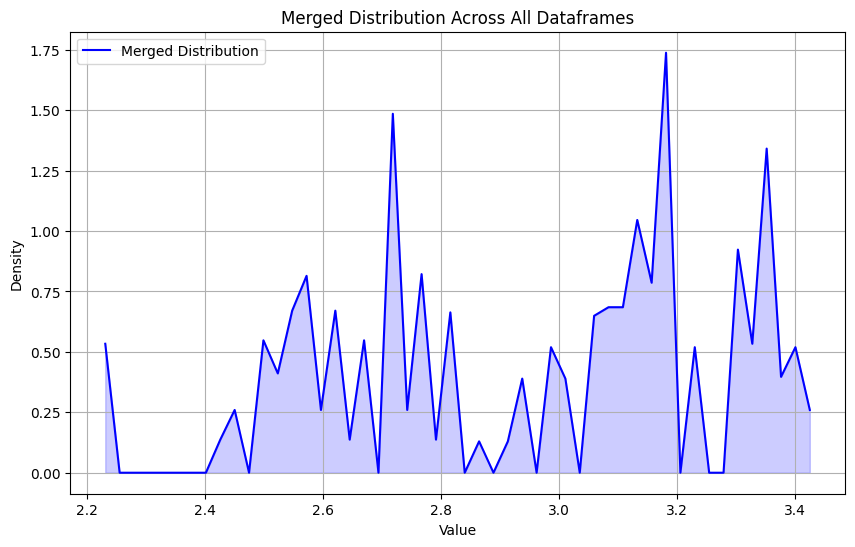

In [87]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/MD/md_conf_snap_2/frames'
process_dataframes(folder_path, columns, smooth_distribution, smooth_tolerance, bin_size, n_bins, merge_distributions=True, sliding_window=3)

## Merge Distribution = False

In this case
- All the PDB files in the folder are **processed into a single data frame**
- But the data for each column is grouped into its own single distribution 
- The plot of the distribution is visualized for each column

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Processing done


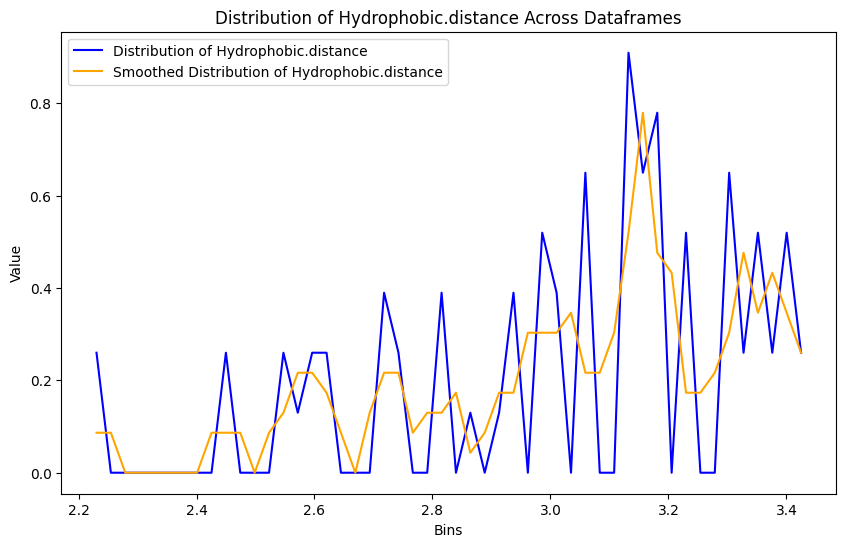

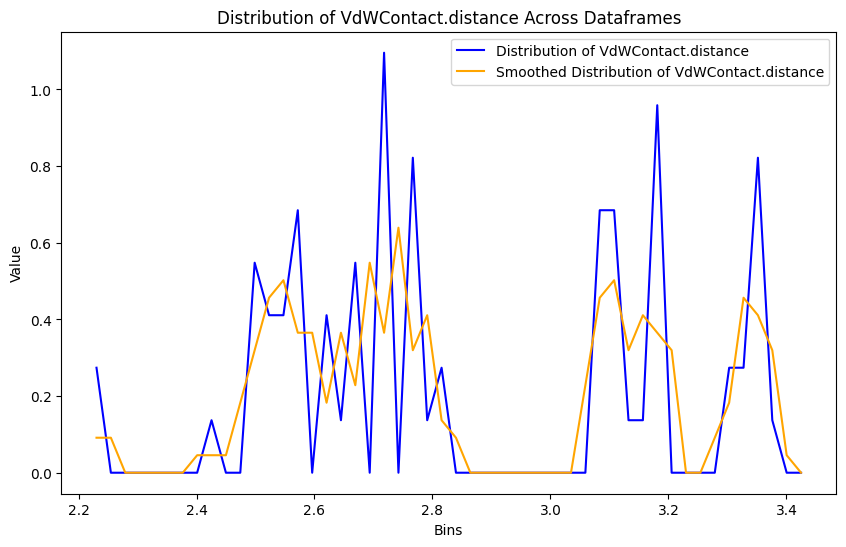

In [88]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/MD/md_conf_snap_2/frames'
process_dataframes(folder_path, columns, smooth_distribution, smooth_tolerance, bin_size, n_bins, merge_distributions=False, sliding_window=3)

## Testing for a2a files (with different ligands)

For this it is best to place the individual PDB file (with the non-LLM suffix) in another folder and choose that as the folder for processing. 

  0%|          | 0/1 [00:00<?, ?it/s]

Processing done


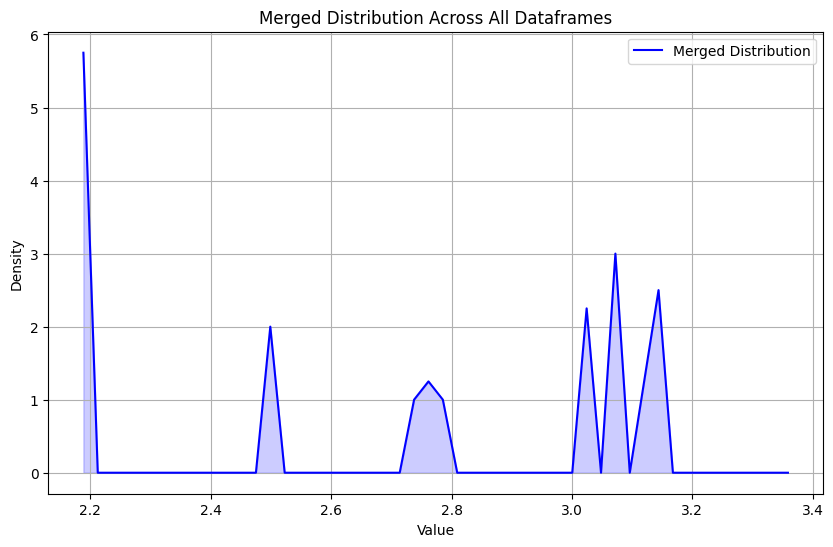

In [89]:
# Input

# For calculating distribution

columns = ['Hydrophobic.distance','VdWContact.distance'] # Change to the columns you need, or set to None to include all columns
smooth_distribution=0
smooth_tolerance=3
bin_size=0.1
n_bins=50

# For visualization
sliding_window=3

## For processing PDB files
box_size = 10.0
ligand_name = "ADN" # Change to the corresponding letters in the new folder a2a, like ADN, NEC etc.
ligand_path = None  # If you have a common ligand file, otherwise set to None


folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/a2a/test'
process_dataframes(folder_path, columns, smooth_distribution, smooth_tolerance, bin_size, n_bins, merge_distributions=True, sliding_window=3)


  0%|          | 0/1 [00:00<?, ?it/s]

Processing done


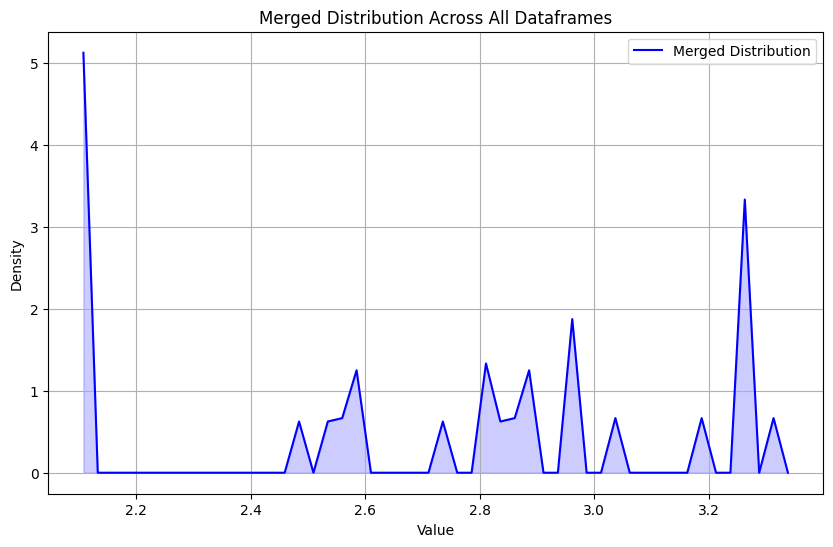

In [90]:
# Input

# For calculating distribution

columns = ['Hydrophobic.distance','VdWContact.distance'] # Change to the columns you need, or set to None to include all columns
smooth_distribution=0
smooth_tolerance=3
bin_size=0.1
n_bins=50

# For visualization
sliding_window=3

## For processing PDB files
box_size = 10.0
ligand_name = "NEC" # Change to the corresponding letters in the new folder a2a, like ADN, NEC etc.
ligand_path = None  # If you have a common ligand file, otherwise set to None


folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/a2a/NEC'
process_dataframes(folder_path, columns, smooth_distribution, smooth_tolerance, bin_size, n_bins, merge_distributions=True, sliding_window=3)
